In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from catboost import CatBoostClassifier
from lime.lime_tabular import LimeTabularExplainer
from scipy.stats import uniform, randint  
import pickle
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")

In [7]:
# Load the dataset
df = pd.read_csv('../data/PCOS_data.csv')

# Clean column names
df.columns = (
    df.columns
    .str.strip()
    .str.replace(' ', '_')
    .str.replace(r'[^\w]', '', regex=True)
)

# Drop unnecessary columns
df.drop(columns=['Sl_No', 'Patient_File_No', 'Unnamed_44'], errors='ignore', inplace=True)

# Convert columns to numeric
for col in df.columns:
    if col != 'PCOS_YN':
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Fill missing values with median
df.fillna(df.median(numeric_only=True), inplace=True)

# Encode binary Y/N columns
yn_cols = ['PregnantYN', 'Weight_gainYN', 'hair_growthYN', 'Skin_darkening_YN',
           'Hair_lossYN', 'PimplesYN', 'Fast_food_YN', 'RegExerciseYN']
df[yn_cols] = df[yn_cols].replace({'Y': 1, 'N': 0})

# Replace zero values with NaN and impute again
num_cols = df.select_dtypes(include=['float64', 'int64']).columns.drop('PCOS_YN')
df[num_cols] = df[num_cols].replace(0, np.nan)
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

In [8]:
# Split features and target
X = df.drop('PCOS_YN', axis=1)
y = df['PCOS_YN']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [9]:
# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Check class distribution after SMOTE
print("Class distribution after SMOTE:", np.bincount(y_train_resampled))

Class distribution after SMOTE: [291 291]


In [12]:
# Initialize CatBoost model
base_model = CatBoostClassifier(loss_function='Logloss', verbose=0, random_state=42)

# Define hyperparameter space
param_dist = {
    'iterations': randint(100, 700),
    'depth': randint(4, 12),
    'learning_rate': uniform(0.01, 0.1),
    'l2_leaf_reg': randint(1, 10),
    'border_count': randint(32, 255)
}

# Randomized search
random_search = RandomizedSearchCV(
    estimator=base_model,
    param_distributions=param_dist,
    n_iter=20,
    cv=3,
    verbose=2,
    scoring='f1',
    n_jobs=-1
)

# Fit the model
random_search.fit(X_train_resampled, y_train_resampled)

# Best model
best_model = random_search.best_estimator_
print("Best parameters:", random_search.best_params_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters: {'border_count': 126, 'depth': 11, 'iterations': 298, 'l2_leaf_reg': 1, 'learning_rate': np.float64(0.040249290785937676)}


In [13]:
# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=200, max_depth=12, random_state=42)
rf_model.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(max_depth=12, n_estimators=200, random_state=42)

In [18]:
# Create Voting Ensemble
ensemble_model = VotingClassifier(
    estimators=[('catboost', best_model), ('random_forest', rf_model)],
    voting='soft',
    weights=[2, 1]
)

# Fit Ensemble
ensemble_model.fit(X_train_resampled, y_train_resampled)

VotingClassifier(estimators=[('catboost',
                              <catboost.core.CatBoostClassifier object at 0x0000011A74BB71D0>),
                             ('random_forest',
                              RandomForestClassifier(max_depth=12,
                                                     n_estimators=200,
                                                     random_state=42))],
                 voting='soft', weights=[2, 1])

In [19]:
# Predict
y_pred_ensemble = ensemble_model.predict(X_test_scaled)

# Evaluation
print("Ensemble Results:")
print(classification_report(y_test, y_pred_ensemble))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_ensemble))
print("Accuracy: {:.4f}".format(accuracy_score(y_test, y_pred_ensemble)))

Ensemble Results:
              precision    recall  f1-score   support

           0       0.90      0.88      0.89        73
           1       0.76      0.81      0.78        36

    accuracy                           0.85       109
   macro avg       0.83      0.84      0.84       109
weighted avg       0.86      0.85      0.85       109

Confusion Matrix:
 [[64  9]
 [ 7 29]]
Accuracy: 0.8532


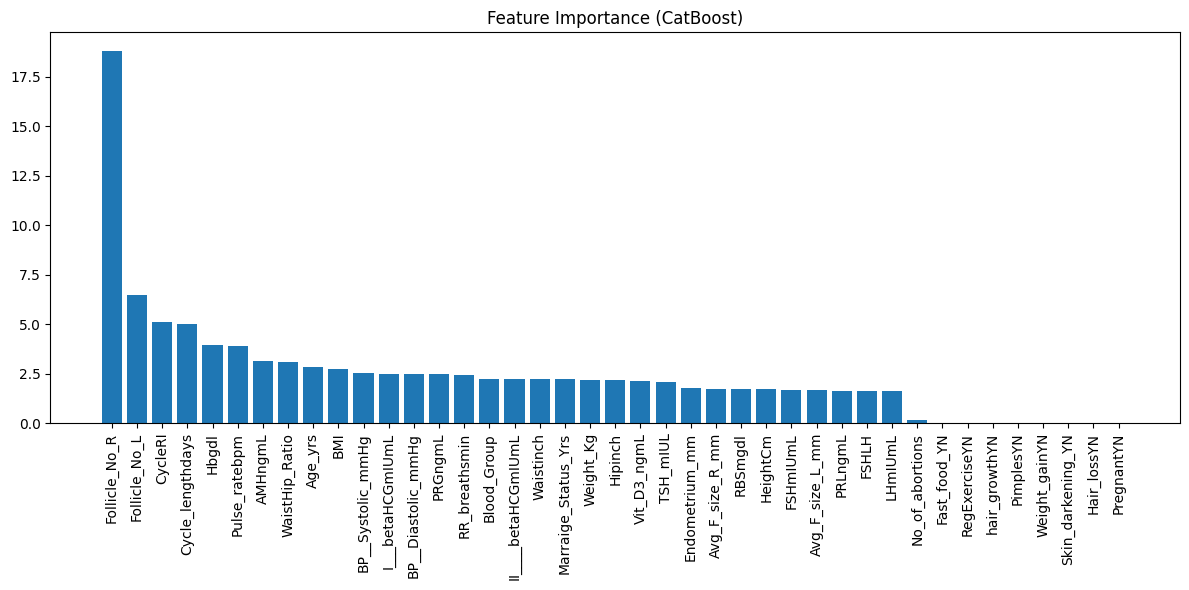

In [20]:
# Feature Importance
importances = best_model.get_feature_importance()
indices = np.argsort(importances)[::-1]
feature_names = X.columns

plt.figure(figsize=(12, 6))
plt.title("Feature Importance (CatBoost)")
plt.bar(range(len(importances)), importances[indices], align='center')
plt.xticks(range(len(importances)), np.array(feature_names)[indices], rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
# Save the trained ensemble model
with open("../models/pcos_ensemble_model.pkl", "wb") as f:
    pickle.dump(ensemble_model, f)

# Save the scaler
with open("../models/pcos_scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

# Save the feature names
with open("../models/pcos_feature_names.pkl", "wb") as f:
    pickle.dump(X.columns.tolist(), f)

# Save the training data
with open("../models/pcos_training_data.pkl", "wb") as f:
    pickle.dump(X_train_resampled, f)

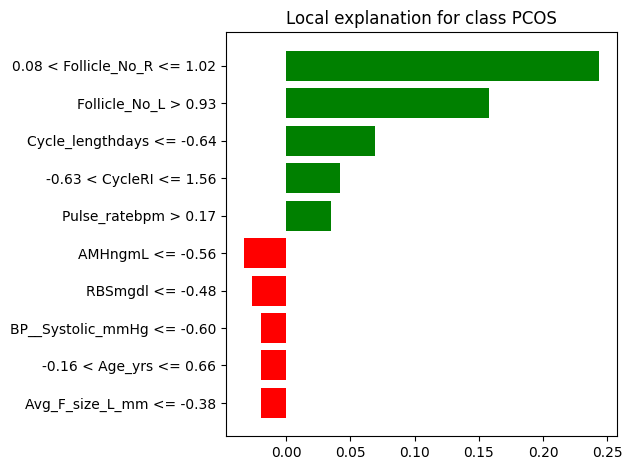

In [21]:
# Create LIME explainer
explainer = LimeTabularExplainer(
    training_data=X_train_resampled,
    feature_names=X.columns,
    class_names=['No PCOS', 'PCOS'],
    mode='classification',
    discretize_continuous=True
)

# Select a random test instance for explanation
idx = 12  # Pick an index from the test set for explanation
instance = X_test_scaled[idx]

# Explain the model's prediction for the chosen instance
explanation = explainer.explain_instance(instance, ensemble_model.predict_proba)

# Plot the explanation
fig = explanation.as_pyplot_figure()
plt.tight_layout()
plt.show()

In [26]:
# Ensure all dependencies and models are in scope
import numpy as np
import matplotlib.pyplot as plt
from lime.lime_tabular import LimeTabularExplainer

# Select a test instance
idx = np.random.randint(0, X_test_scaled.shape[0])
instance = X_test_scaled[idx]

# Predict risk score and label
proba = ensemble_model.predict_proba([instance])[0][1]
pred_label = ensemble_model.predict([instance])[0]

# Print prediction result
print(f" Test Instance Index: {idx}")
print(f" Predicted Label: {'PCOS' if pred_label == 1 else 'No PCOS'}")
print(f" Predicted PCOS Risk Score: {proba * 100:.2f}%")

# Create LIME explainer (if not already created)
explainer = LimeTabularExplainer(
    training_data=X_train_resampled,
    feature_names=X.columns.tolist(),
    class_names=['No PCOS', 'PCOS'],
    mode='classification',
    discretize_continuous=True
)

# Explain prediction
explanation = explainer.explain_instance(instance, ensemble_model.predict_proba, num_features=10)



# Show explanation as text
print("\n Top Contributing Features to Prediction:\n")
for feature, weight in explanation.as_list():
    direction = "↑ increases" if weight > 0 else "↓ decreases"
    print(f"- {feature}: {direction} PCOS risk ({weight:.4f})")



 Test Instance Index: 51
 Predicted Label: No PCOS
 Predicted PCOS Risk Score: 15.38%

 Top Contributing Features to Prediction:

- Follicle_No_R <= -0.63: ↓ decreases PCOS risk (-0.3173)
- Follicle_No_L <= -0.53: ↓ decreases PCOS risk (-0.1251)
- AMHngmL > 0.47: ↑ increases PCOS risk (0.0492)
- CycleRI <= -0.63: ↓ decreases PCOS risk (-0.0479)
- Pulse_ratebpm <= -0.25: ↓ decreases PCOS risk (-0.0454)
- No_of_abortions <= -0.23: ↑ increases PCOS risk (0.0254)
- RBSmgdl <= -0.48: ↓ decreases PCOS risk (-0.0253)
- FSHmIUmL > -0.04: ↓ decreases PCOS risk (-0.0226)
- Age_yrs <= -0.81: ↑ increases PCOS risk (0.0209)
- -0.64 < Cycle_lengthdays <= 0.02: ↓ decreases PCOS risk (-0.0171)
